In [1]:
#import required libraries
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Try out Convolution and deconvolution and get to know the dimenitions 

In [2]:
y=torch.randn(1,3,32, 32)
c = nn.Conv2d(3, 6, 5)
out = c(y)
print(out.shape) 

y=torch.randn(1, 6, 28, 28)
c = nn.Conv2d(6, 3, 5,2,4)
out = c(y)
print(out.shape) 

c=nn.ConvTranspose2d(3, 6, 5,2,4,output_padding=1)
out = c(out)
print(out.shape)

c=nn.ConvTranspose2d(6, 3, 5,1,0)
out = c(out)
print(out.shape)


torch.Size([1, 6, 28, 28])
torch.Size([1, 3, 16, 16])
torch.Size([1, 6, 28, 28])
torch.Size([1, 3, 32, 32])


# Auto Encoder using Convolutions

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size-->[batch, 3, 32, 32]
        # Output size:--> [batch, 3, 32, 32]
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, 
        #groups=1, bias=True, padding_mode='zeros')
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 5),           
            nn.ReLU(),
            nn.Conv2d(6, 3, 5,stride=2,padding=4),          
            nn.ReLU(),
        )
        #torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 6, 5,stride=2,padding=4,output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 5),  
            nn.Sigmoid(),
        )

    def forward(self, x):
        #forward the input data(x) through encoder and decoder to get back the input image back
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# My inference on Auto Encoder using Convolutions :
I have used two convolution layers with filter size 5X5 in encoder, In the second convolution layer using stride=2 and padding to get the output of 16X16X3 i.e half of 32X32X3 for each channel.
In the decoder part two ConvTranspose2d  layers are used to bring back the original dimentions of the image back.


# Auto Encoder using Fully Connected Layers

In [4]:
class Autoencoder_FC(nn.Module):
    def __init__(self):
        super(Autoencoder_FC, self).__init__()
        # Input size-->[batch, 3, 32, 32]
        # Output size-->[batch, 3, 32, 32]
        #FLatten the input and pass through Fully connected layers in encoder and decoders
        self.encoder = nn.Sequential(
           nn.Linear(32*32*3, 2304),
            nn.ReLU(True),
            nn.Linear(2304, 1536),
            nn.ReLU(True), 
        )
        self.decoder = nn.Sequential(
            nn.Linear(1536, 2304),
            nn.ReLU(True),
            nn.Linear(2304, 32*32*3),
            nn.Sigmoid(),
            
        )

    def forward(self, x):
        #forward the input data(x) through encoder and decoder to get back the input image back
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# My inference on Auto Encoder with Full Connected Layers
I flattend the image (32X32X3) into one dimentional array to feed into fully connected layers(3072X1).
encoder with two fully connected layer reduced input to half (1536X1) and decoder with two fully connected layer again upsamples it back to original dimention.

# Load the CIFAR10 dataset

In [5]:
#the following block of code defines the necessay data loaders for trainng and testing. 
#I have fixed the batch size of 16
#I am applying ToTensor() so that the inputs fed into network are in Tensors
transform = transforms.Compose(
    [transforms.ToTensor(), ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Define  Training Function for Autoencoder

In [6]:
#the below code trains the Auto encoder defined using Convolutions 
def train(auto_encoder):
    for epoch in range(500):
            running_loss = 0.0
            for i, (inputs, _) in enumerate(trainloader, 0):
                #If GPU available pushing the variables to GPU for faster training
                if torch.cuda.is_available():
                    inputs = inputs.cuda()

                #  Forward propagation of the batch
                encoded, outputs = auto_encoder(inputs)
                loss = criterion(outputs, inputs)
                # Back propagation of the batch
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # printing the loss 
                running_loss += loss.data
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0

    print('Finished Training')

# Train the Auto Encoder defined using Convolutions

In [7]:
#create an instance of Autencoder and display the struture
autoencoder = Autoencoder()
print("============== Encoder ==============")
print(autoencoder.encoder)
print("============== Decoder ==============")
print(autoencoder.decoder)
if torch.cuda.is_available():
    autoencoder = autoencoder.cuda()
    print("Model moved to GPU in order to speed up training.")

============== Encoder ==============
Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 3, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (3): ReLU()
)
============== Decoder ==============
Sequential(
  (0): ConvTranspose2d(3, 6, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4), output_padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
  (3): Sigmoid()
)
Model moved to GPU in order to speed up training.


# Define loss function and Optimizer


In [8]:
#Define the loss function and the optimizer required to train the network
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(autoencoder.parameters())

In [9]:
#call the train function
train(autoencoder)

[1,  2000] loss: 671.356
[2,  2000] loss: 319.295
[3,  2000] loss: 261.414
[4,  2000] loss: 235.072
[5,  2000] loss: 220.778
[6,  2000] loss: 208.176
[7,  2000] loss: 186.345
[8,  2000] loss: 173.933
[9,  2000] loss: 167.474
[10,  2000] loss: 161.447
[11,  2000] loss: 156.774
[12,  2000] loss: 154.648
[13,  2000] loss: 150.022
[14,  2000] loss: 147.998
[15,  2000] loss: 145.855
[16,  2000] loss: 143.704
[17,  2000] loss: 142.580
[18,  2000] loss: 140.343
[19,  2000] loss: 139.592
[20,  2000] loss: 138.034
[21,  2000] loss: 136.482
[22,  2000] loss: 135.902
[23,  2000] loss: 134.519
[24,  2000] loss: 133.516
[25,  2000] loss: 132.983
[26,  2000] loss: 131.928
[27,  2000] loss: 131.201
[28,  2000] loss: 129.344
[29,  2000] loss: 129.336
[30,  2000] loss: 129.314
[31,  2000] loss: 127.740
[32,  2000] loss: 127.414
[33,  2000] loss: 127.439
[34,  2000] loss: 126.641
[35,  2000] loss: 125.999
[36,  2000] loss: 125.649
[37,  2000] loss: 125.338
[38,  2000] loss: 125.783
[39,  2000] loss: 124

[309,  2000] loss: 106.883
[310,  2000] loss: 106.374
[311,  2000] loss: 106.731
[312,  2000] loss: 106.578
[313,  2000] loss: 106.548
[314,  2000] loss: 106.142
[315,  2000] loss: 106.488
[316,  2000] loss: 106.697
[317,  2000] loss: 106.572
[318,  2000] loss: 106.913
[319,  2000] loss: 106.335
[320,  2000] loss: 106.130
[321,  2000] loss: 106.265
[322,  2000] loss: 106.700
[323,  2000] loss: 106.314
[324,  2000] loss: 105.600
[325,  2000] loss: 106.302
[326,  2000] loss: 106.049
[327,  2000] loss: 106.720
[328,  2000] loss: 106.198
[329,  2000] loss: 105.854
[330,  2000] loss: 106.307
[331,  2000] loss: 106.507
[332,  2000] loss: 106.621
[333,  2000] loss: 106.912
[334,  2000] loss: 106.589
[335,  2000] loss: 106.040
[336,  2000] loss: 106.473
[337,  2000] loss: 106.074
[338,  2000] loss: 105.899
[339,  2000] loss: 106.192
[340,  2000] loss: 106.280
[341,  2000] loss: 106.235
[342,  2000] loss: 105.843
[343,  2000] loss: 106.155
[344,  2000] loss: 106.481
[345,  2000] loss: 106.455
[

# Test the trained AutoEncoder using Convolutions

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


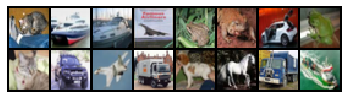

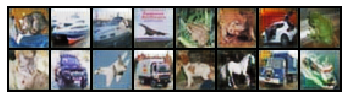

In [10]:
#the below logic tests the trained model and visulizes how well our model has learnt the input represntation.
def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())
decoded_imgs = autoencoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

# Train the Auto Encoder defined using Fully Connected Layers

In [16]:
#train function for Auto encoders with Fully connected Layers
def train_2(auto_encoder):
    for epoch in range(150):
            running_loss = 0.0
            for i, (inputs, _) in enumerate(trainloader, 0):
                #if GPU available use it
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                #Since we are using Fully connected layers we need to flatten the data to suit for the layer
                inputs=inputs.view(inputs.size(0), -1)

                # Forward propagation
                encoded, outputs = auto_encoder(inputs)
                loss = criterion(outputs, inputs)
                # Backward propagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Logging the loss
                running_loss += loss.data
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0

    print('Finished Training')

In [21]:
autoencoder_fc = Autoencoder_FC()
print("============== Encoder ==============")
print(autoencoder_fc.encoder)
print("============== Decoder ==============")
print(autoencoder_fc.decoder)
if torch.cuda.is_available():
    autoencoder_fc = autoencoder_fc.cuda()
    print("Model moved to GPU in order to speed up training.")

============== Encoder ==============
Sequential(
  (0): Linear(in_features=3072, out_features=2304, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=2304, out_features=1536, bias=True)
  (3): ReLU(inplace=True)
)
============== Decoder ==============
Sequential(
  (0): Linear(in_features=1536, out_features=2304, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=2304, out_features=3072, bias=True)
  (3): Sigmoid()
)
Model moved to GPU in order to speed up training.


In [18]:
#using the same loss function as before
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(autoencoder_fc.parameters())

In [19]:
train_2(autoencoder_fc)

[1,  2000] loss: 1403.555
[2,  2000] loss: 890.681
[3,  2000] loss: 786.177
[4,  2000] loss: 743.458
[5,  2000] loss: 713.434
[6,  2000] loss: 704.022
[7,  2000] loss: 699.017
[8,  2000] loss: 695.956
[9,  2000] loss: 691.616
[10,  2000] loss: 690.520
[11,  2000] loss: 683.636
[12,  2000] loss: 686.109
[13,  2000] loss: 684.708
[14,  2000] loss: 683.385
[15,  2000] loss: 680.729
[16,  2000] loss: 679.844
[17,  2000] loss: 679.607
[18,  2000] loss: 677.261
[19,  2000] loss: 678.022
[20,  2000] loss: 674.780
[21,  2000] loss: 675.817
[22,  2000] loss: 673.702
[23,  2000] loss: 673.598
[24,  2000] loss: 673.737
[25,  2000] loss: 669.385
[26,  2000] loss: 670.419
[27,  2000] loss: 669.278
[28,  2000] loss: 669.395
[29,  2000] loss: 671.011
[30,  2000] loss: 668.900
[31,  2000] loss: 669.777
[32,  2000] loss: 668.842
[33,  2000] loss: 669.311
[34,  2000] loss: 668.480
[35,  2000] loss: 668.065
[36,  2000] loss: 666.242
[37,  2000] loss: 668.594
[38,  2000] loss: 667.321
[39,  2000] loss: 66

# Test the Test the trained AutoEncoder using Fully Connected Layers

torch.Size([16, 3, 32, 32])
GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship


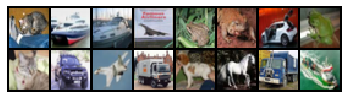

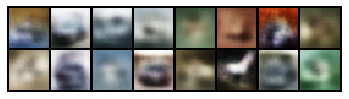

In [20]:
#Testing the trained network
def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.shape)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))

imshow(torchvision.utils.make_grid(images))
images=images.view(images.size(0), -1)
images = Variable(images.cuda())
decoded_imgs = autoencoder_fc(images)[1]
decoded_imgs=decoded_imgs.view(16, 3, 32, 32)
imshow(torchvision.utils.make_grid(decoded_imgs.data))
